# LJ Potential Benchmarking

Benchmarking TMol LJ-potential implementation.

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first, merge

In [3]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [4]:
import tmol.tests.data

In [5]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [6]:
import tmol.score

In [7]:
import torch

In [8]:
import functools

In [34]:
import tmol.score.ljlk.numba_potential

def benchmark_decoys():
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 600:
            continue
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        
        coords_c = coords.cuda()
        types_c = types.cuda()
        path_length_c = path_length.cuda()

        ljlk_resolver_c = ljlk_resolver.from_database(score_graph.ljlk_database, device=torch.device("cuda"))
        
        @subfixture(fixture, platform="cpu")
        def cpu_serial():
            return tmol.score.ljlk.numba_potential.lj_kernel(
                coords,
                types,
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
                parallel=False,
            ).sum()
            
        @subfixture(fixture, platform="cpu")
        def cpu_parallel():
            return tmol.score.ljlk.numba_potential.lj_kernel(
                coords,
                types,
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
            ).sum()
            
                
        inputs = dict(
            a_types = types_c,
            b_types = types_c,
            a_b_bonded_path_length = path_length_c,
        )
        preorg_inputs = {n : numba.cuda.as_cuda_array(p) for n, p in inputs.items() }
        
        params = dict(
         lj_sigma=           ljlk_resolver_c.pair_params.lj_sigma,
         lj_switch_slope=           ljlk_resolver_c.pair_params.lj_switch_slope,
         lj_switch_intercept=           ljlk_resolver_c.pair_params.lj_switch_intercept,
         lj_coeff_sigma12=           ljlk_resolver_c.pair_params.lj_coeff_sigma12,
         lj_coeff_sigma6=           ljlk_resolver_c.pair_params.lj_coeff_sigma6,
         lj_spline_y0=           ljlk_resolver_c.pair_params.lj_spline_y0,
         lj_spline_dy0=           ljlk_resolver_c.pair_params.lj_spline_dy0,
            
          lj_switch_dis2sigma=          ljlk_resolver_c.global_params.lj_switch_dis2sigma,
          spline_start=          ljlk_resolver_c.global_params.spline_start,
          max_dis=          ljlk_resolver_c.global_params.max_dis,
        )
        
        preorg_params = {n : numba.cuda.as_cuda_array(p) for n, p in params.items() }
        
        
        @subfixture(fixture, platform="cuda")
        def cuda():
            try:
                return tmol.score.ljlk.numba_potential.lj_kernel(
                    a_coords = coords_c,
                    b_coords = coords_c,
                    **merge(inputs, params)
                ).sum()
            finally:
                torch.cuda.synchronize()
        
        @subfixture(fixture, platform="cuda")
        def cuda_preorg_params():
            try:
                return tmol.score.ljlk.numba_potential.lj_kernel(
                    a_coords = coords_c,
                    b_coords = coords_c,
                    **merge(inputs, preorg_params)
                ).sum()
            finally:
                torch.cuda.synchronize()
                
        @subfixture(fixture, platform="cuda")
        def cuda_preorg_all():
            try:
                return tmol.score.ljlk.numba_potential.lj_kernel(
                    a_coords = coords_c,
                    b_coords = coords_c,
                    **merge(preorg_inputs, preorg_params)
                ).sum()
            finally:
                torch.cuda.synchronize()
            
        logging.info(f"cpu_serial: {cpu_serial} cpu_parallel: {cpu_parallel} cuda: {cuda} cuda_preorg_all: {cuda_preorg_all}")
        
    return stats

In [35]:
decoys = tmol.tests.data.structures_bysize()

In [36]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys()

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu_serial: -169.0110626220703 cpu_parallel: -169.0110626220703 cuda: -169.01095581054688 cuda_preorg_all: -169.01095581054688
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu_serial: -18.480274200439453 cpu_parallel: -18.480274200439453 cuda: -18.480239868164062 cuda_preorg_all: -18.480239868164062
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:cpu_serial: -308.2018127441406 cpu_parallel: -308.2018127441406 cuda: -308.20184326171875 cuda_preorg_all: -308.20184326171875
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:root:BYSIZE_300_RES_6F8B
INFO:root:cpu_serial: -429.61126708984375 cpu_parallel: -429.61126708984375 cuda: -429.6112365722656 cuda_preorg_all: -429.6112365722656
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:cpu_serial: -156.0329284667968

In [39]:
import pandas
import seaborn
from matplotlib import pyplot

In [40]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpu_serial'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

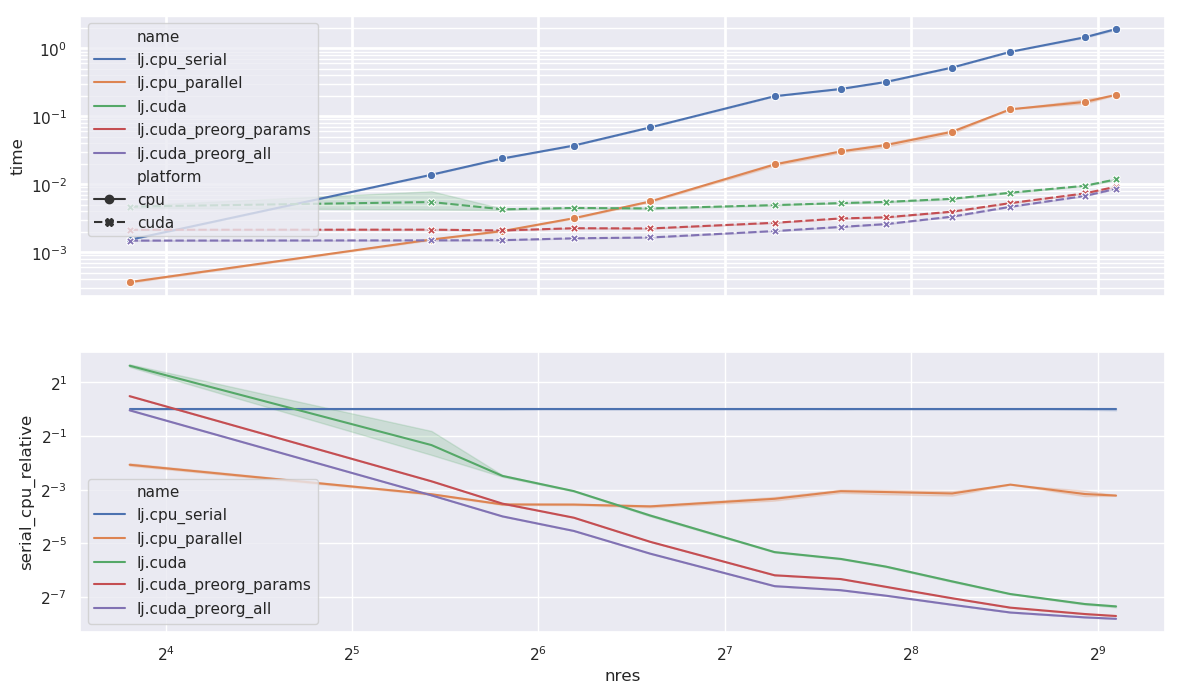

In [41]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers=True)

In [46]:
(
    dat.query("name=='lj.cuda_preorg_all'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14              0.972966  0.001482            3.160811  0.004814   
43              0.108070  0.001494            0.161282  0.002230   
56              0.062722  0.001504            0.087501  0.002098   
73              0.043076  0.001602            0.051475  0.001914   
97              0.023940  0.001647            0.032492  0.002236   
154             0.010339  0.002048            0.011792  0.002336   
197             0.009307  0.002356            0.013621  0.003448   
233             0.008079  0.002595            0.012841  0.004124   
298             0.006389  0.003341            0.007601  0.003975   
370             0.005230  0.004663            0.005392  0.004807   
488             0.004612  0.006729            0.004939  0.007206   
548             0.004446  0.008579            0.004528  0.008738   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.087876  0.000134  
43              0.003000  0.000041  
56              0.004888  0.000117  
73              0.000917  0.000034  
97              0.001531  0.000105  
154             0.000196  0.000039  
197             0.000324  0.000082  
233             0.000428  0.000137  
298             0.000212  0.000111  
370             0.000038  0.000033  
488             0.000053  0.000077  
548             0.000022  0.000042